# Load libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

# Load in dataframe

In [ ]:
with zipfile.ZipFile('/content/project_2_training.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('')

training_df = pd.read_csv('project_2_training.csv')

training_df.head()

,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,2608000,5774.0,2172.0,78.0,4523.0,81.237.240.91,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like M...,graves.org,456-910-9478,South Angelaville,...,R,2021-02-21 16:32:23,Kristi Bell,7683 Chavez Curve,882-35-3409,es_VE,Q,82.0,4609.0,legit
1,214500,5405.0,2887.0,51.0,4057.0,160.32.216.178,Mozilla/5.0 (Macintosh; PPC Mac OS X 10 10_7) ...,howard-madden.com,269.363.8079,Lake Leslietown,...,O,2020-12-30 11:36:17,Amanda Bond,628 Cline Streets,453-93-1357,bhb_IN,S,2.0,12384.0,legit
2,294600,6570.0,2887.0,56.0,5602.0,109.156.235.28,Mozilla/5.0 (Windows NT 6.2) AppleWebKit/535.2...,walsh-goodwin.com,366.185.9975,Lake Kendra,...,C,2021-03-24 05:34:28,Joanna Walton,268 Ashley Plaza Apt. 416,554-51-8940,mi_NZ,W,43.0,9607.0,legit
3,477060,3865.0,1591.0,58.0,3926.0,158.152.249.45,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,gonzalez-diaz.com,816-365-8213,East Maryport,...,G,2021-10-12 16:24:49,Matthew Johnson,8377 Jacob Course,492-66-7677,yue_HK,Y,71.0,10305.0,legit
4,1993100,6625.0,3297.0,70.0,6675.0,167.164.91.31,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,bender-rocha.info,001-970-935-1735x19620,Yorkburgh,...,W,2021-06-23 00:05:15,Susan Phillips,401 Christopher Meadows,468-86-6030,gd_GB,Q,52.0,4139.0,legit


In [ ]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   EVENT_ID               125000 non-null  int64  
 1   account_age_days       125000 non-null  float64
 2   transaction_amt        125000 non-null  float64
 3   transaction_adj_amt    125000 non-null  float64
 4   historic_velocity      125000 non-null  float64
 5   ip_address             124896 non-null  object 
 6   user_agent             124905 non-null  object 
 7   email_domain           124924 non-null  object 
 8   phone_number           124898 non-null  object 
 9   billing_city           124906 non-null  object 
 10  billing_postal         124902 non-null  float64
 11  billing_state          124906 non-null  object 
 12  card_bin               124890 non-null  float64
 13  currency               124906 non-null  object 
 14  cvv                    124898 non-nu

## How much fraud is there in the dataset?

In [ ]:
training_df['billing_postal'] = training_df['billing_postal'].astype(object)

In [ ]:
training_df['EVENT_LABEL'].value_counts(normalize = True)

legit    0.94572
fraud    0.05428
Name: EVENT_LABEL, dtype: float64

## Since ~5.5% of the dataset is fraud, we do not need to perform upsampling or SMOTE

## The default accuracy is 94.572%; if we classified every transaction as legit, we would be correct 94.572% of the time. This will be our benchmark.

## Count Null values

In [ ]:
training_df.isna().sum()

EVENT_ID                   0
account_age_days           0
transaction_amt            0
transaction_adj_amt        0
historic_velocity          0
ip_address               104
user_agent                95
email_domain              76
phone_number             102
billing_city              94
billing_postal            98
billing_state             94
card_bin                 110
currency                  94
cvv                      102
signature_image           92
transaction_type          98
transaction_env          104
EVENT_TIMESTAMP           90
applicant_name           124
billing_address          111
merchant_id               89
locale                   115
tranaction_initiate      100
days_since_last_logon    113
inital_amount            109
EVENT_LABEL                0
dtype: int64

## Let's look at the columns!

In [ ]:
df = training_df

In [ ]:
def df_profile(df, target):

    df = df.copy()

    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]

    categorical_features = [ c for c in df.select_dtypes(include = "object").columns ]

    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)
    # -- part 2
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    # df_stats.loc[df_stats["dtype"] == "float64", 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"] == target, 'feature_type'] = "TARGET"


    # -- part 3
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats["nunique_pct"] > 0.7,'feature_warning' ] = "EXCLUDE, GT 70% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

df_profile(df, "churn")

<ipython-input-9-275104fd8acd>:10: FutureWarning: ['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'EVENT_TIMESTAMP', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate', 'EVENT_LABEL'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)


,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,EVENT_ID,int64,125000,125000,1500443.74368,20.0,2999960.0,0,125000,0.000000,1.000000,NUMERIC,"EXCLUDE, GT 70% UNIQUE"
1,account_age_days,float64,125000,6363,4642.453544,-1.0,9119.0,0,125000,0.000000,0.050904,NUMERIC,NO WARNING
2,transaction_amt,float64,125000,3641,2519.545384,-1.0,4880.0,0,125000,0.000000,0.029128,NUMERIC,NO WARNING
3,transaction_adj_amt,float64,125000,93,54.142104,-1.0,99.0,0,125000,0.000000,0.000744,NUMERIC,NO WARNING
4,historic_velocity,float64,125000,6633,4699.900328,-1.0,8875.0,0,125000,0.000000,0.053064,NUMERIC,NO WARNING
5,days_since_last_logon,float64,124887,101,49.81432,0.0,100.0,113,124887,0.000904,0.000808,NUMERIC,NO WARNING
6,card_bin,float64,124890,6321,41813.290488,6040.0,67639.0,110,124890,0.000880,0.050568,NUMERIC,NO WARNING
7,inital_amount,float64,124891,13999,7999.642744,1000.0,15000.0,109,124891,0.000872,0.111992,NUMERIC,NO WARNING
8,tranaction_initiate,object,124900,26,NaN,NaN,NaN,100,124900,0.000800,0.000208,CATEGORY,NO WARNING
9,locale,object,124885,293,NaN,NaN,NaN,115,124885,0.000920,0.002344,CATEGORY,NO WARNING


In [ ]:
training_df.T

,0,1,2,3,4,5,6,7,8,9,...,124990,124991,124992,124993,124994,124995,124996,124997,124998,124999
EVENT_ID,2608000,214500,294600,477060,1993100,1810560,1547840,2588820,694280,1968920,...,1792640,1498060,924720,2564080,2177940,2596780,2224380,1073760,1463080,795500
account_age_days,5774.0,5405.0,6570.0,3865.0,6625.0,5513.0,5978.0,3595.0,5126.0,3214.0,...,3436.0,6156.0,5134.0,4399.0,3976.0,5683.0,4102.0,4620.0,6070.0,5542.0
transaction_amt,2172.0,2887.0,2887.0,1591.0,3297.0,2946.0,3093.0,1925.0,2368.0,1520.0,...,2547.0,3216.0,2569.0,2718.0,2712.0,3169.0,2552.0,2302.0,2120.0,3214.0
transaction_adj_amt,78.0,51.0,56.0,58.0,70.0,56.0,53.0,54.0,76.0,48.0,...,43.0,71.0,35.0,20.0,51.0,60.0,58.0,48.0,64.0,54.0
historic_velocity,4523.0,4057.0,5602.0,3926.0,6675.0,6196.0,4679.0,3258.0,5444.0,4343.0,...,4301.0,5324.0,4920.0,5875.0,4128.0,6033.0,5208.0,4384.0,4273.0,6476.0
ip_address,81.237.240.91,160.32.216.178,109.156.235.28,158.152.249.45,167.164.91.31,199.82.244.185,146.80.81.85,217.21.238.26,194.137.69.234,67.102.234.102,...,103.13.136.99,148.90.251.114,217.107.210.109,72.46.163.216,43.181.23.59,41.23.113.3,92.17.206.66,107.203.152.208,168.124.93.20,80.207.128.169
user_agent,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like M...,Mozilla/5.0 (Macintosh; PPC Mac OS X 10 10_7) ...,Mozilla/5.0 (Windows NT 6.2) AppleWebKit/535.2...,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Opera/9.30.(X11; Linux i686; nr-ZA) Presto/2.9...,Opera/9.29.(X11; Linux i686; bo-IN) Presto/2.9...,Opera/9.38.(Windows CE; lij-IT) Presto/2.9.175...,Opera/8.66.(X11; Linux x86_64; fi-FI) Presto/2...,Mozilla/5.0 (Windows; U; Windows NT 6.0) Apple...,...,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Mozilla/5.0 (Windows; U; Windows NT 10.0) Appl...,Mozilla/5.0 (Linux; Android 4.1.2) AppleWebKit...,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_1 like M...,Mozilla/5.0 (iPod; U; CPU iPhone OS 4_1 like M...,Mozilla/5.0 (Windows 98; Win 9x 4.90; wae-CH; ...,Opera/8.63.(X11; Linux i686; bhb-IN) Presto/2....,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10 5...,Mozilla/5.0 (Windows; U; Windows 95) AppleWebK...,Mozilla/5.0 (iPhone; CPU iPhone OS 3_1_3 like ...
email_domain,graves.org,howard-madden.com,walsh-goodwin.com,gonzalez-diaz.com,bender-rocha.info,west.info,thompson-lang.org,williamson-stout.com,smith-bennett.biz,mendez.info,...,johnson-mason.com,graham-bartlett.com,ray.net,santiago-pineda.com,miller-carlson.biz,rivera-keith.com,moore-barr.biz,richards.info,mcgrath.info,williams-lee.net
phone_number,456-910-9478,269.363.8079,366.185.9975,816-365-8213,001-970-935-1735x19620,(240)526-3137x63074,(419)612-9165x88361,219-611-9524x40701,001-647-089-3537x8813,486.447.0125x752,...,+1-748-130-5711x356,(675)392-6669x31376,+1-712-508-8613,+1-409-434-8232,844-415-7597x5919,8608349491,001-205-826-9068x186,710-871-1634x706,001-632-600-8902x8392,(753)777-1458
billing_city,South Angelaville,Lake Leslietown,Lake Kendra,East Maryport,Yorkburgh,Shieldshaven,South Dominic,Port Paulstad,Garyfurt,Rangelbury,...,Peterland,Barkerville,Sabrinahaven,West Angelashire,Port Colinchester,Erichaven,Port Kathyport,Bassbury,Teresaland,New Wendyberg


# Define numerical and categorical columns of interest

In [ ]:
# Identify categorical and numerical columns
categorical_cols = ["tranaction_initiate", "email_domain", "billing_postal", "locale", "currency", "cvv", "signature_image",
                    "transaction_type", "transaction_env"]

numerical_cols = ["account_age_days",	"transaction_amt",	"transaction_adj_amt",
                  "historic_velocity", "days_since_last_logon", "card_bin", "inital_amount"]

feature_names = categorical_cols + numerical_cols
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Define the target variable
y = training_df['EVENT_LABEL'].map({'legit': 0, 'fraud': 1})  # Convert to binary
X = training_df.drop('EVENT_LABEL', axis=1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=223)

# Perform EDA

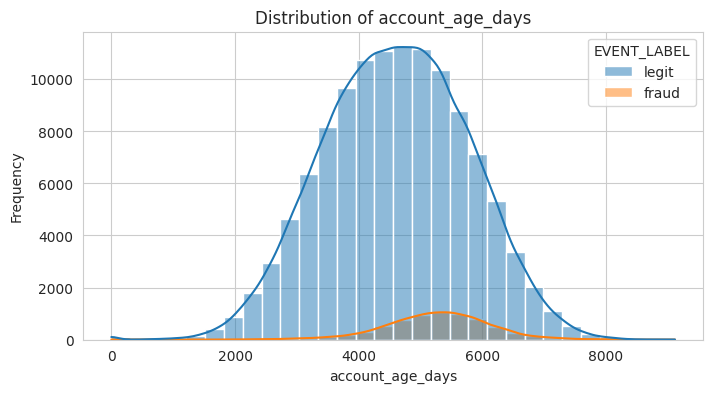

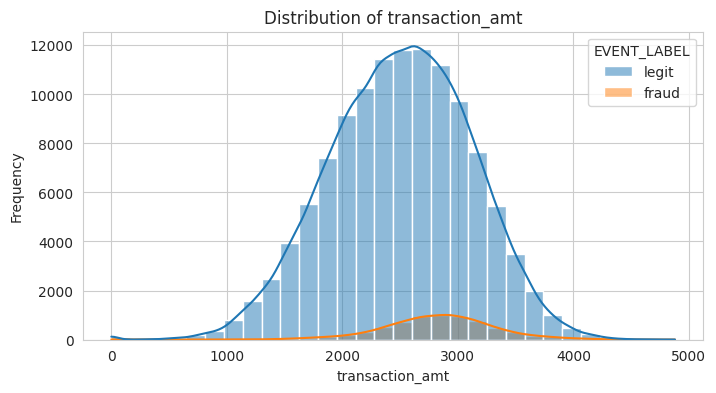

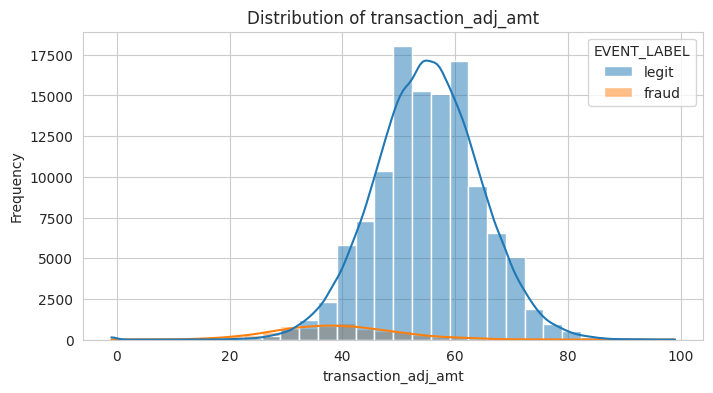

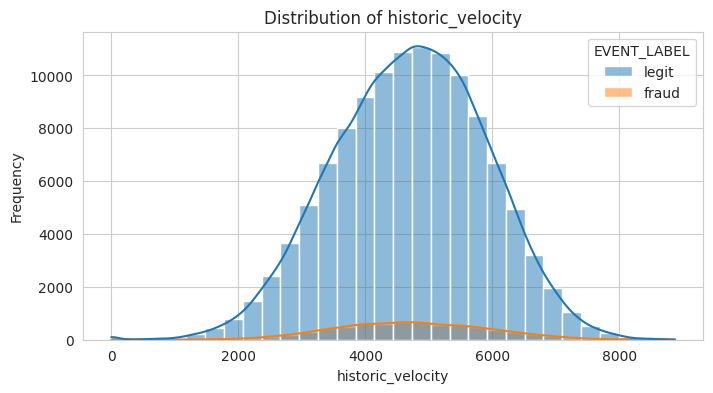

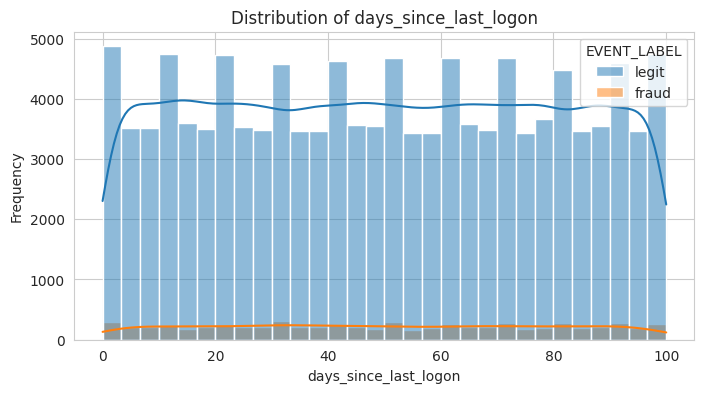

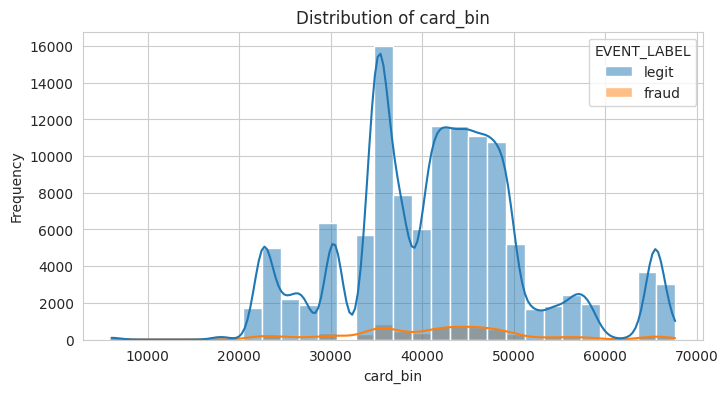

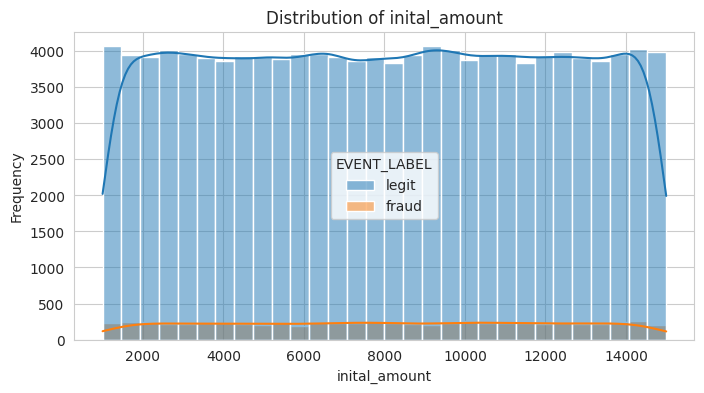

In [ ]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data= training_df, x=col, hue="EVENT_LABEL", kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

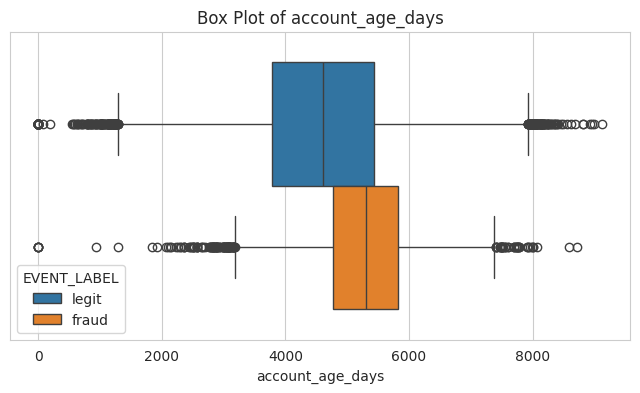

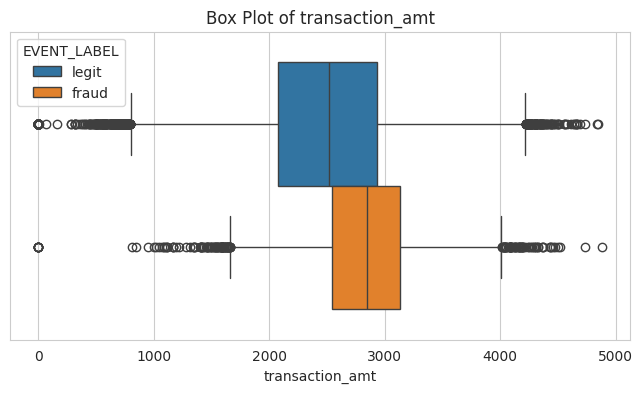

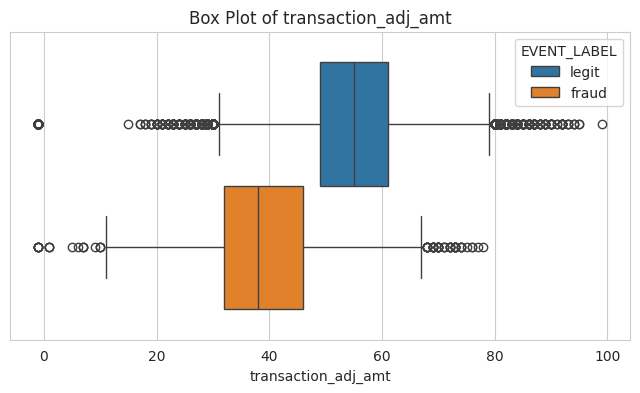

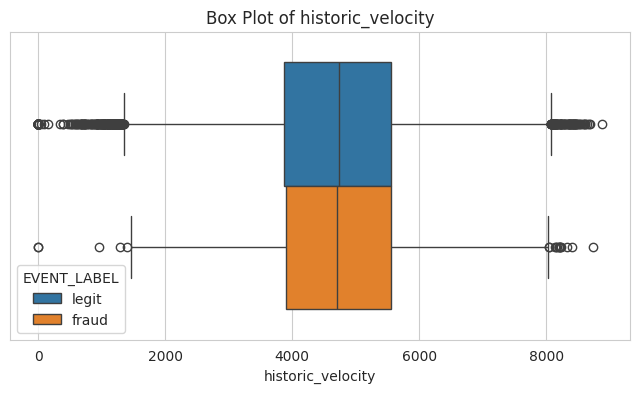

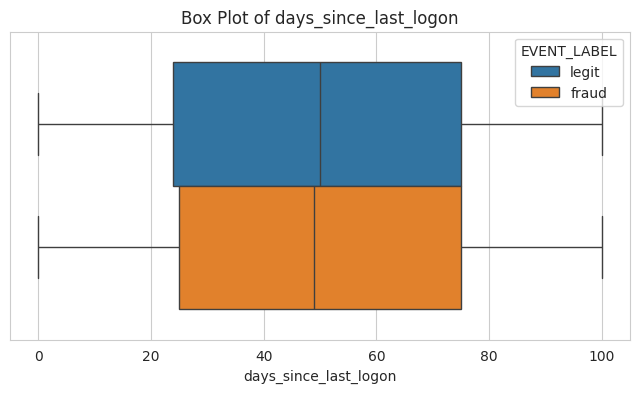

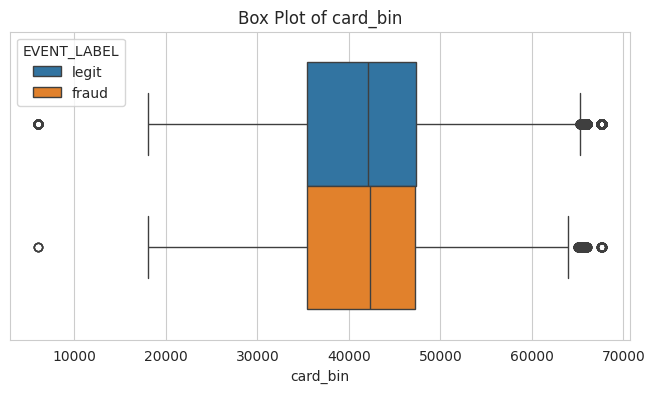

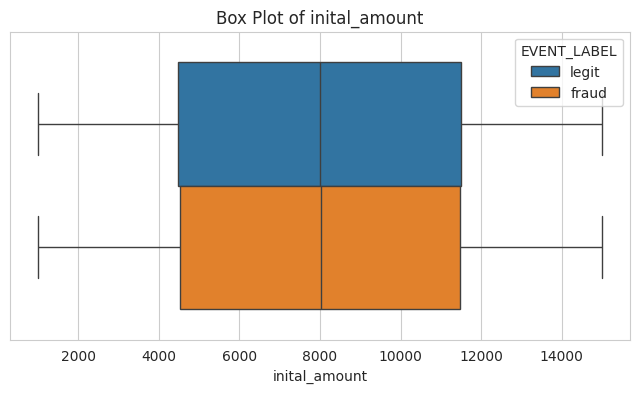

In [ ]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data = training_df, x=col, hue="EVENT_LABEL")
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

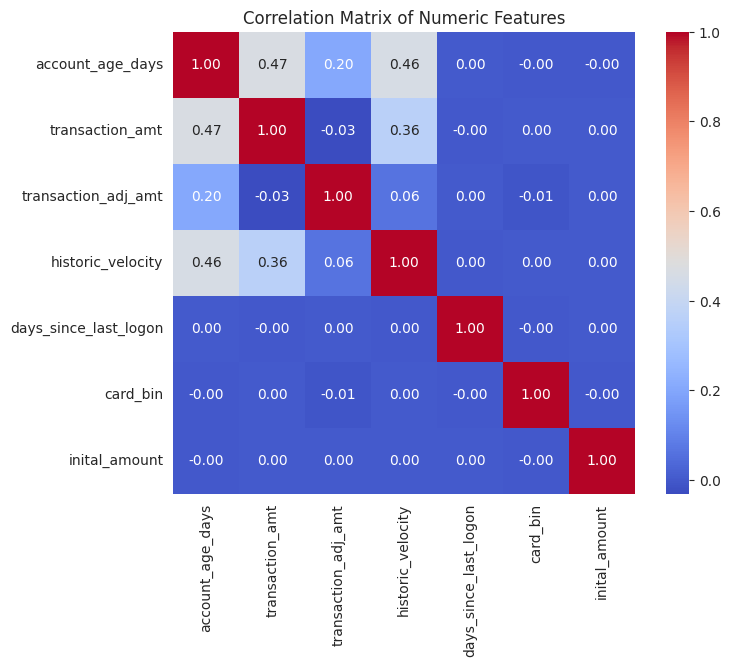

In [ ]:
# Compute the correlation matrix
corr = training_df[numerical_cols].corr()

# Generate a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

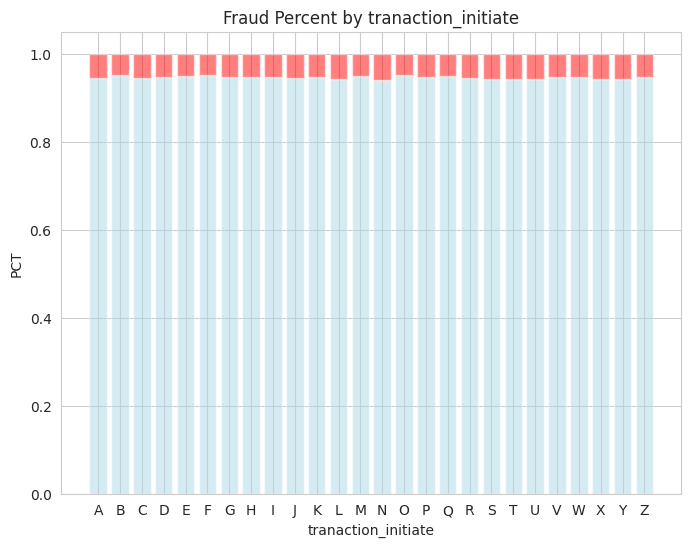

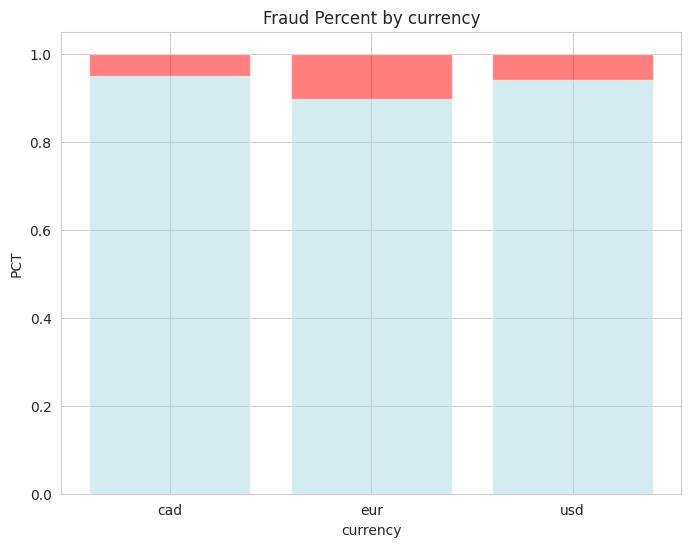

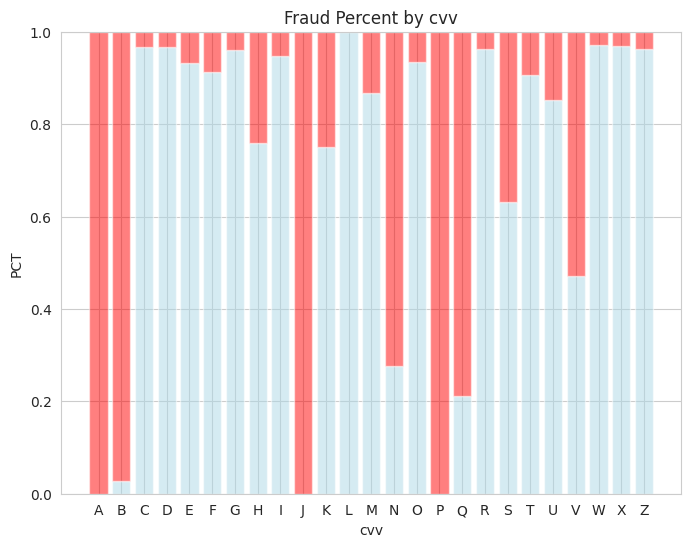

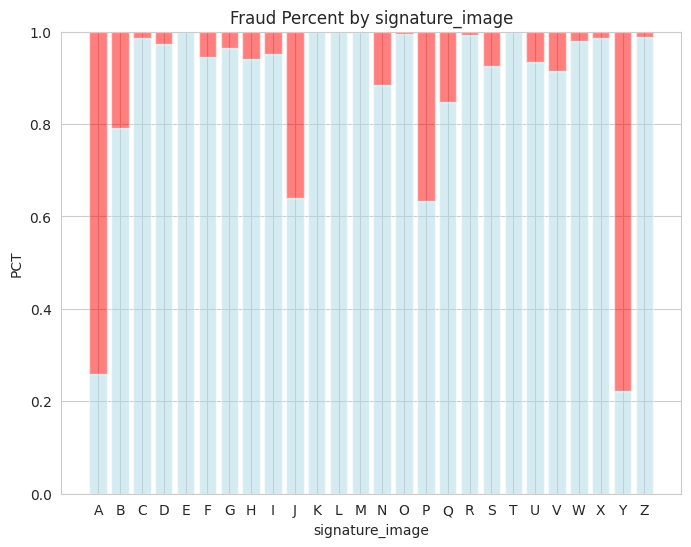

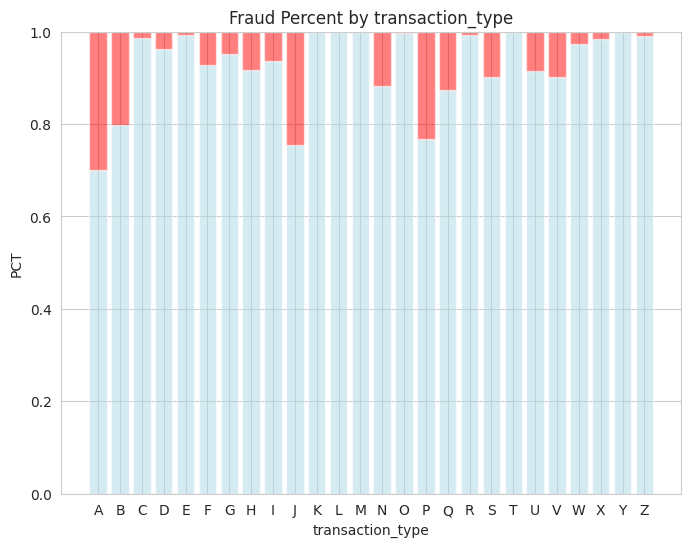

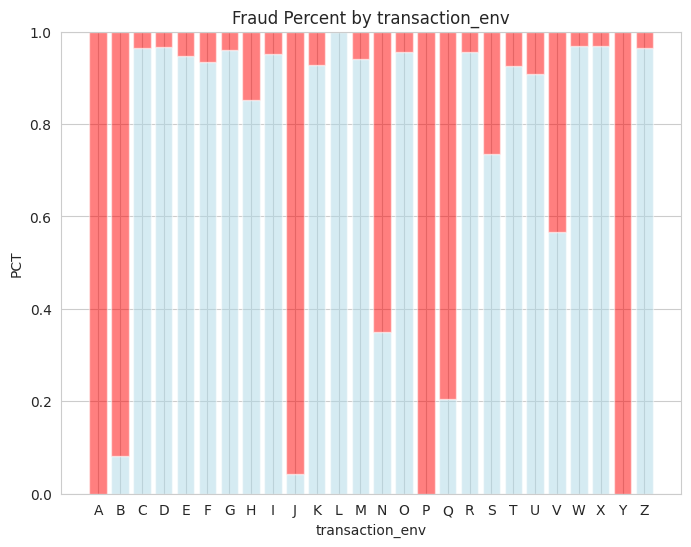

In [ ]:
categorical_columns = ["tranaction_initiate",  "currency", "cvv", "signature_image",
                    "transaction_type", "transaction_env"]

for col in categorical_columns:
    ctab = pd.crosstab(training_df[col], training_df['EVENT_LABEL'], normalize="index").reset_index()
    plt.figure(figsize=(8,6))
    plt.bar(ctab[col].astype('str'), ctab['legit'], facecolor='lightblue', alpha=0.5)
    plt.bar(ctab[col].astype('str'), ctab['fraud'], bottom=ctab['legit'], facecolor='red', alpha=0.5)
    plt.title(f'Fraud Percent by {col}')
    plt.ylabel('PCT')
    plt.xlabel(f'{col}')
    plt.show()

## We can clearly see from the EDA that our numerical and categorical columns of choice appear to be significnant. Let's now build a model!

# We use logistic regression as a baseline

In [ ]:
# Define the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=0, max_iter=300))])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
lr_predictions = lr_pipeline.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f" Precision: {precision_score(y_test, lr_predictions):.4f}")
print(f" Recall: {recall_score(y_test, lr_predictions):.4f}")
print(f" AUC: {roc_auc_score(y_test, lr_predictions):.4f}")
print(f" F1 Score: {f1_score(y_test, lr_predictions):.4f}")

Logistic Regression Accuracy: 0.9748
 Precision: 0.8801
 Recall: 0.6288
 AUC: 0.8119
 F1 Score: 0.7335


In [ ]:
# Predict probabilities for the positive class
y_scores = lr_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

Target FPR: 0.01, Expected TPR: 0.7144, Threshold: 0.3403
Target FPR: 0.02, Expected TPR: 0.7706, Threshold: 0.2178
Target FPR: 0.03, Expected TPR: 0.8093, Threshold: 0.1549
Target FPR: 0.04, Expected TPR: 0.8311, Threshold: 0.1197
Target FPR: 0.05, Expected TPR: 0.8495, Threshold: 0.0974
Target FPR: 0.06, Expected TPR: 0.8577, Threshold: 0.0813
Target FPR: 0.07, Expected TPR: 0.8698, Threshold: 0.0696
Target FPR: 0.08, Expected TPR: 0.8766, Threshold: 0.0602
Target FPR: 0.09, Expected TPR: 0.8804, Threshold: 0.0532
Target FPR: 0.10, Expected TPR: 0.8858, Threshold: 0.0472


# Get feature importance

In [ ]:
feature_names = preprocessor.get_feature_names_out()
feature_importance = lr_pipeline.named_steps['classifier'].coef_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance[0]})
feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importance_df.head(n=10)

,feature,importance
0,num__account_age_days,1.542442
1,num__transaction_amt,0.143018
2,num__transaction_adj_amt,-1.756039
3,num__historic_velocity,-0.107703
4,num__days_since_last_logon,0.007199
5,num__card_bin,-0.002088
6,num__inital_amount,-0.011678
7,cat__tranaction_initiate_A,0.064427
8,cat__tranaction_initiate_B,-0.000039
9,cat__tranaction_initiate_C,-0.057929


In [ ]:
# Logistic Regression coefficients as feature importance
lr_coefficients = lr_pipeline.named_steps['classifier'].coef_[0]

# Aligning feature names and coefficients
lr_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})
lr_feature_importance_df = lr_feature_importance_df.sort_values(by='Coefficient', ascending=False)
lr_feature_importance_df.head(10)

,Feature,Coefficient
17647,cat__transaction_env_B,2.831561
17582,cat__cvv_N,2.419300
17621,cat__transaction_type_B,2.312173
10809,cat__billing_postal_39517.0,2.282416
17655,cat__transaction_env_J,2.238826
17662,cat__transaction_env_Q,2.170705
17585,cat__cvv_Q,2.103913
17636,cat__transaction_type_Q,2.092955
17646,cat__transaction_env_A,2.053267
17603,cat__signature_image_J,2.037656


# Plot feature importance

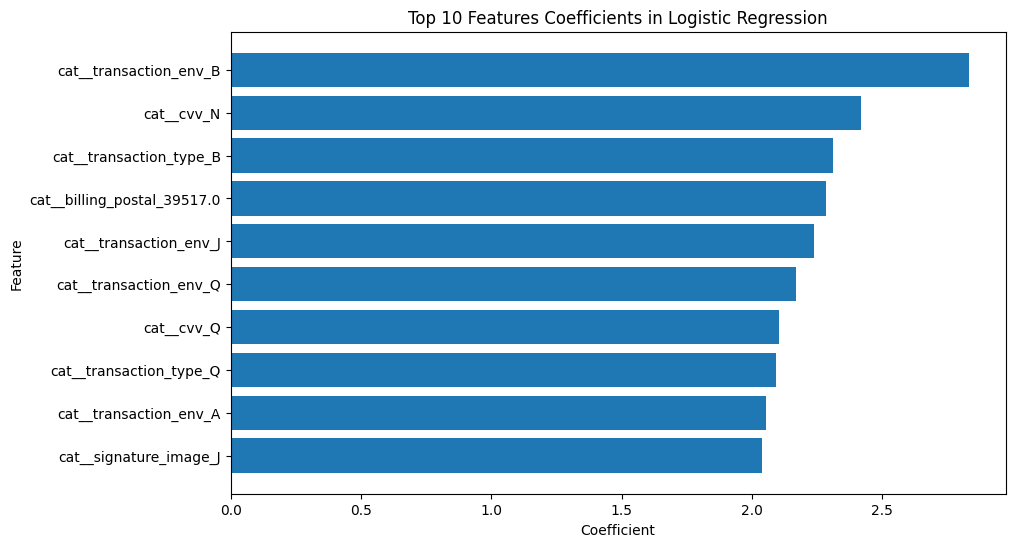

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Top 10 Features Coefficients in Logistic Regression')
plt.barh(lr_feature_importance_df['Feature'][:10], lr_feature_importance_df['Coefficient'][:10])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

## Plot ROC Curve and Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression Test Data')

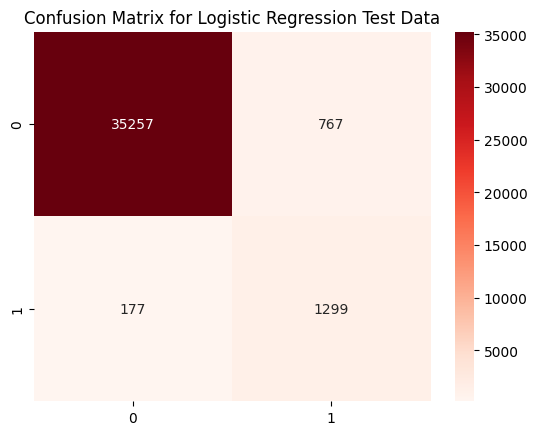

In [ ]:
conf_matrix = confusion_matrix(lr_predictions, y_test)
sns.heatmap(conf_matrix, fmt='.5g', annot=True, cmap = "Reds")
plt.title("Confusion Matrix for Logistic Regression Test Data")

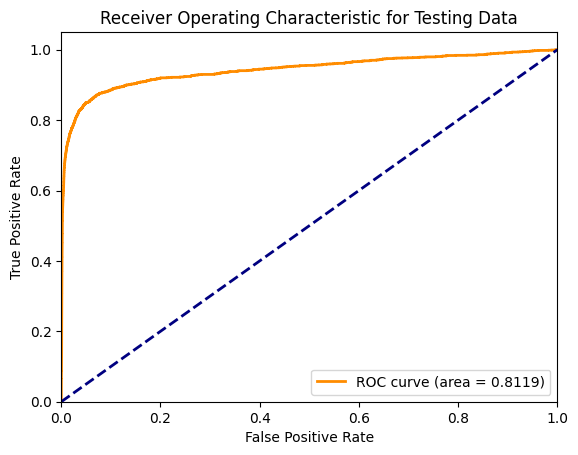

In [ ]:
roc_auc = roc_auc_score(y_test, lr_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

# Create a Random Forest Pipeline

In [ ]:
# Define the Random Forest pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=50, n_jobs = -1, random_state=223))])
# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
rf_predictions = rf_pipeline.predict(X_test)
rf_predictions_proba = rf_pipeline.predict_proba(X_test)[:,1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")

Random Forest Accuracy: 0.9591


In [ ]:
# Predict probabilities for the positive class
y_scores = rf_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

Target FPR: 0.01, Expected TPR: 0.6956, Threshold: 0.2361
Target FPR: 0.02, Expected TPR: 0.7520, Threshold: 0.1797
Target FPR: 0.03, Expected TPR: 0.7868, Threshold: 0.1474
Target FPR: 0.04, Expected TPR: 0.8076, Threshold: 0.1290
Target FPR: 0.05, Expected TPR: 0.8228, Threshold: 0.1158
Target FPR: 0.06, Expected TPR: 0.8331, Threshold: 0.1056
Target FPR: 0.07, Expected TPR: 0.8415, Threshold: 0.0973
Target FPR: 0.08, Expected TPR: 0.8473, Threshold: 0.0915
Target FPR: 0.09, Expected TPR: 0.8531, Threshold: 0.0856
Target FPR: 0.10, Expected TPR: 0.8588, Threshold: 0.0799


In [ ]:
# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Print the metrics
print("Random Forest Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")

Random Forest Model Evaluation:
  Accuracy: 0.9591
  AUC: 0.9282
  Precision: 0.9855
  Recall: 0.2623


# Perform hyperparameter tuning on the Random Forest

In [ ]:
# Create the parameter grid
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [20, 30, 50],
    #'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [5, 10],
    #'classifier__min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters:
  classifier__min_samples_split: 5
  classifier__n_estimators: 50


## Results of the grid search

In [ ]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

<Axes: xlabel='param_classifier__n_estimators', ylabel='mean_test_score'>

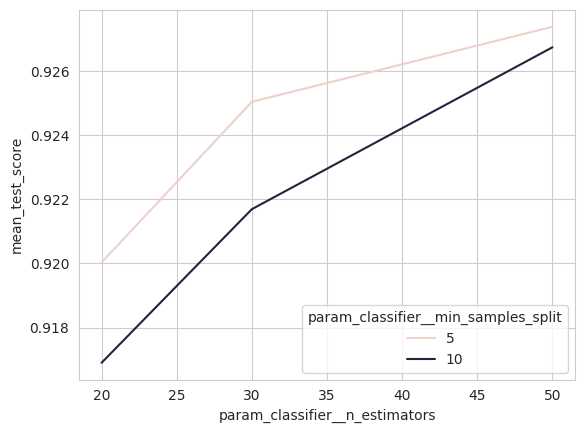

In [ ]:
sns.lineplot(data=cv_results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__min_samples_split')

## Refit with best parameters

In [ ]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=50,
                                                                    min_samples_split=5,
                                                                    n_jobs=-1,
                                                                    random_state=42))])
# Train the pipeline
rf_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'transaction_adj_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'card_bin',
                                                   'inital_amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tranaction_initiate',
                                                   'email_domain',
                                                   'billing_postal', 'locale',
                                                   'currency', 'cvv',
                                                   'signature_image',
                                                   'transaction_type',
                                                   'transaction_env'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=50,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# compare rf_pipeline to rf_pipeline_hpo performance
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf_hpo = rf_pipeline_hpo.predict(X_test)
y_pred_proba_rf_hpo = rf_pipeline_hpo.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Random Forest Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_rf):.4f}")

print("\n -------- \n")
print("Random Forest Model Evaluation with HPO:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf_hpo):.4f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_rf_hpo):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf_hpo):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf_hpo):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_rf_hpo):.4f}")

Random Forest Model Evaluation:
  Accuracy: 0.9591
  AUC: 0.9282
  Precision: 0.9855
  Recall: 0.2623
  F1 Score: 0.4144

 -------- 

Random Forest Model Evaluation with HPO:
  Accuracy: 0.9608
  AUC: 0.9302
  Precision: 0.9822
  Recall: 0.2938
  F1 Score: 0.4523


## Generate a Confusion Matrix and ROC Curve

Text(0.5, 1.0, 'Confusion Matrix for Tuned Random Forest Test Data')

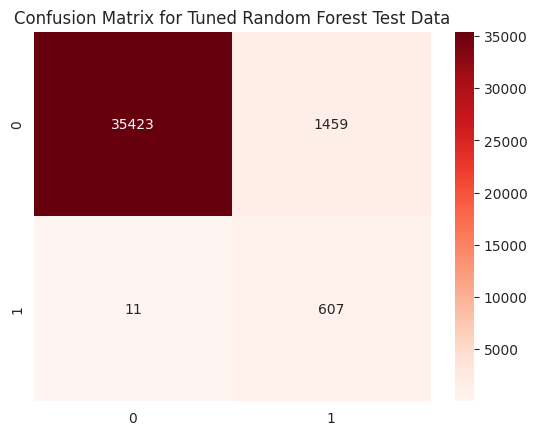

In [ ]:
conf_matrix = confusion_matrix(y_pred_rf_hpo, y_test)
sns.heatmap(conf_matrix, fmt='.5g', annot=True, cmap = "Reds")
plt.title("Confusion Matrix for Tuned Random Forest Test Data")

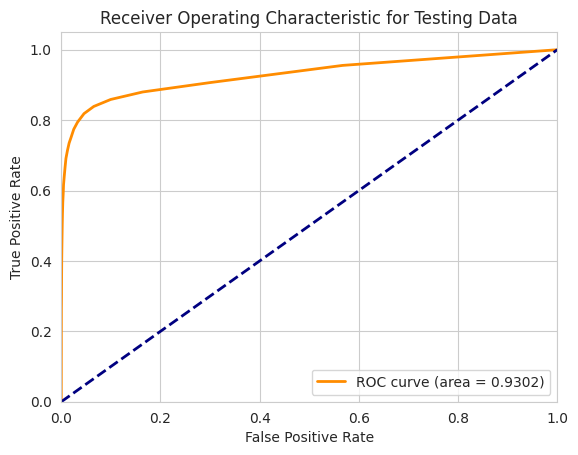

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba_rf_hpo)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

# Get feature importance

In [ ]:
y_scores = rf_pipeline_hpo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Add Precision Column
precisions = []

for threshold in interp_thresholds:
  y_pred = (y_scores >= threshold).astype(int)
  precision = precision_score(y_test, y_pred)
  precisions.append(precision)

target_fpr_df['Precision'] = precisions

target_fpr_df

# Display the DataFrame
target_fpr_df

,Target FPR (%),Expected TPR,Threshold,Precision
0,1.0,0.708616,0.225457,0.805281
1,2.0,0.769119,0.164870,0.691772
2,3.0,0.794288,0.133801,0.607103
3,4.0,0.812682,0.113977,0.542839
4,5.0,0.821878,0.100845,0.489478
5,6.0,0.832043,0.091453,0.447190
6,7.0,0.837367,0.084677,0.411122
7,8.0,0.846079,0.078333,0.380994
8,9.0,0.849468,0.073207,0.354976
9,10.0,0.855003,0.068333,0.333082


In [ ]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

rf_importances = rf_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
rf_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)
rf_feature_importance_df.head(10)

,Feature,Importance
2,transaction_adj_amt,0.134429
0,account_age_days,0.038413
1,transaction_amt,0.024839
3,historic_velocity,0.023782
5,card_bin,0.013723
6,inital_amount,0.012436
4,days_since_last_logon,0.011375
17659,transaction_env_N,0.011242
17667,transaction_env_V,0.010114
17590,cvv_V,0.008907


# Plot feature importance

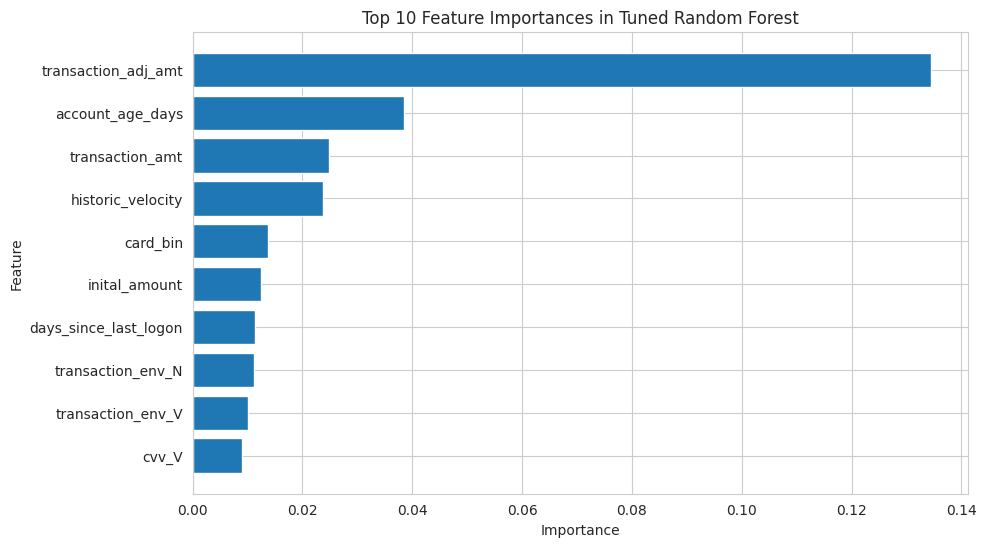

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances in Tuned Random Forest')
plt.barh(rf_feature_importance_df['Feature'][:10], rf_feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Initiate a GBM

In [ ]:
# Initialize the pipeline with the preprocessor and a Gradient Boosting classifier
gbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(
                                                                        learning_rate=0.1, n_estimators=100,
                                                                    ))])
# Train the pipeline
gbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'transaction_adj_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'card_bin',
                                                   'inital_amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tranaction_initiate',
                                                   'email_domain',
                                                   'billing_postal', 'locale',
                                                   'currency', 'cvv',
                                                   'signature_image',
                                                   'transaction_type',
                                                   'transaction_env'])])),
                ('classifier', GradientBoostingClassifier())])

In [ ]:
# Predictions
y_pred_gbm = gbm_pipeline.predict(X_test)
y_pred_proba_gbm = gbm_pipeline.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_gbm)
auc_rf = roc_auc_score(y_test, y_pred_proba_gbm)
precision_rf = precision_score(y_test, y_pred_gbm)
recall_rf = recall_score(y_test, y_pred_gbm)

# Print the metrics
print("GB Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")

GB Model Evaluation:
  Accuracy: 0.9726
  AUC: 0.9384
  Precision: 0.8844
  Recall: 0.5779


In [ ]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(gbm_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters:
  classifier__learning_rate: 0.2
  classifier__n_estimators: 200


In [ ]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,42.573558,3.919547,0.383148,0.007859,0.05,100,"{'classifier__learning_rate': 0.05, 'classifie...",0.921894,0.927579,0.930204,0.926559,0.003468,6
1,71.992389,1.133803,0.543219,0.104406,0.05,200,"{'classifier__learning_rate': 0.05, 'classifie...",0.931727,0.935548,0.938099,0.935125,0.002619,5
2,35.630544,0.480089,0.396204,0.021822,0.1,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.932045,0.937096,0.937896,0.935679,0.002590,4
3,74.724109,0.929889,0.701329,0.232256,0.1,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.936314,0.939671,0.940068,0.938684,0.001684,2
4,35.719845,1.680626,0.489621,0.151639,0.2,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.933543,0.939038,0.939751,0.937444,0.002774,3
5,64.333707,6.189537,0.702664,0.471517,0.2,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.936535,0.940411,0.940292,0.939079,0.001800,1


<Axes: xlabel='param_classifier__n_estimators', ylabel='mean_test_score'>

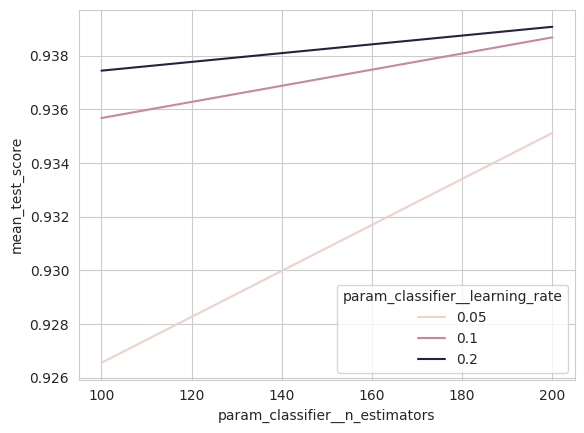

In [ ]:
sns.lineplot(data=cv_results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__learning_rate')

In [ ]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
gbm_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(n_estimators=200,
                                                                    learning_rate=0.2,
                                                                    ))])
# Train the pipeline
gbm_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'transaction_adj_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'card_bin',
                                                   'inital_amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tranaction_initiate',
                                                   'email_domain',
                                                   'billing_postal', 'locale',
                                                   'currency', 'cvv',
                                                   'signature_image',
                                                   'transaction_type',
                                                   'transaction_env'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2,
                                            n_estimators=200))])

In [ ]:
y_pred_gbm  = gbm_pipeline.predict(X_test)
y_pred_proba_gbm = gbm_pipeline.predict_proba(X_test)[:, 1]

y_pred_gbm_hpo  = gbm_pipeline_hpo.predict(X_test)
y_pred_proba_gbm_hpo = gbm_pipeline_hpo.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("GBM Baseline:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_gbm):.3f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_gbm):.3f}")


print("\n -------- ")
print("GBM Optimized:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm_hpo):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_gbm_hpo):.3f}")

GBM Baseline:
  Accuracy: 0.973
  AUC: 0.938
  Precision: 0.884
  Recall: 0.578
  F1 Score: 0.699

 -------- 
GBM Optimized:
  Accuracy: 0.975
  AUC: 0.941
  Precision: 0.865
  Recall: 0.652
  F1 Score: 0.744


In [ ]:
y_scores = gbm_pipeline_hpo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Add Precision Column
precisions = []

for threshold in interp_thresholds:
  y_pred = (y_scores >= threshold).astype(int)
  precision = precision_score(y_test, y_pred)
  precisions.append(precision)

target_fpr_df['Precision'] = precisions

target_fpr_df

,Target FPR (%),Expected TPR,Threshold,Precision
0,1.0,0.724105,0.332103,0.808649
1,2.0,0.788480,0.172308,0.697047
2,3.0,0.817038,0.117520,0.613818
3,4.0,0.838335,0.088362,0.550016
4,5.0,0.848669,0.070762,0.497446
5,6.0,0.857212,0.057973,0.454452
6,7.0,0.866893,0.049242,0.419340
7,8.0,0.877541,0.042434,0.390144
8,9.0,0.883833,0.037174,0.364108
9,10.0,0.890126,0.032870,0.341695


In [ ]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

gbm_importances = gbm_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
gbm_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbm_importances})
gbm_feature_importance_df = gbm_feature_importance_df.sort_values(by='Importance', ascending=False)
gbm_feature_importance_df.head(10)

,Feature,Importance
2,transaction_adj_amt,0.421881
0,account_age_days,0.176699
3,historic_velocity,0.073366
17568,currency_usd,0.038803
17587,cvv_S,0.020907
17590,cvv_V,0.019851
17659,transaction_env_N,0.018575
17582,cvv_N,0.017822
17638,transaction_type_S,0.014191
1,transaction_amt,0.013874


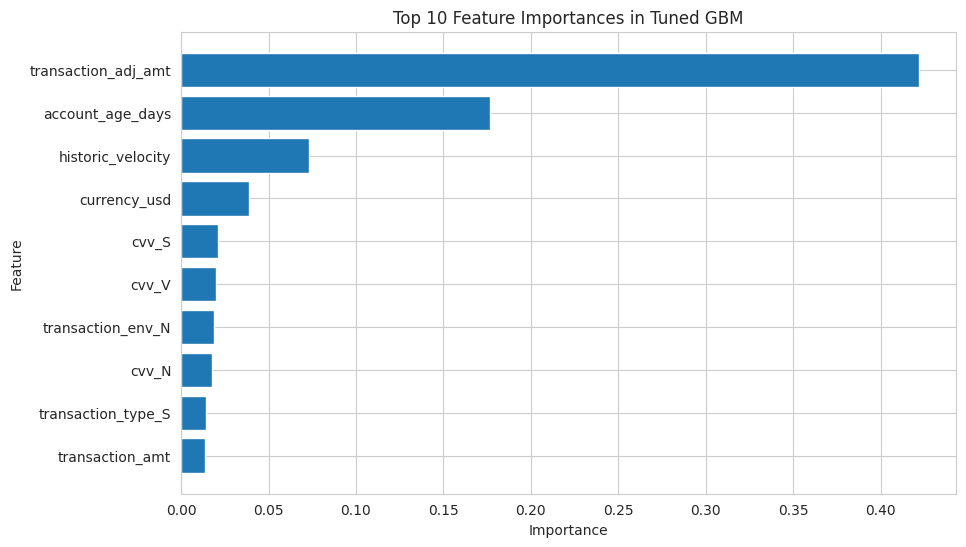

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances in Tuned GBM')
plt.barh(gbm_feature_importance_df['Feature'][:10], gbm_feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

## Plot Confusion Matix and ROC Curve

Text(0.5, 1.0, 'Confusion Matrix for Tuned GBM Test Data')

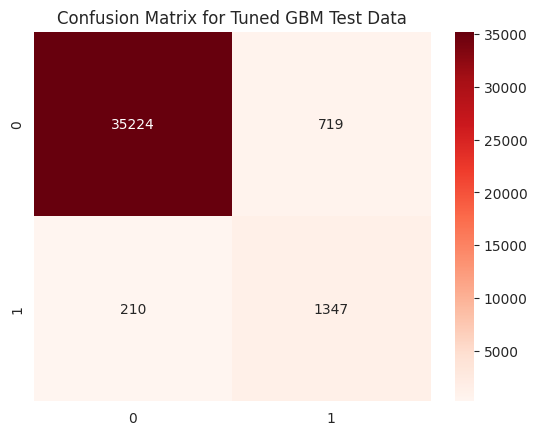

In [ ]:
conf_matrix = confusion_matrix(y_pred_gbm_hpo, y_test)
sns.heatmap(conf_matrix, fmt='.5g', annot=True, cmap = "Reds")
plt.title("Confusion Matrix for Tuned GBM Test Data")

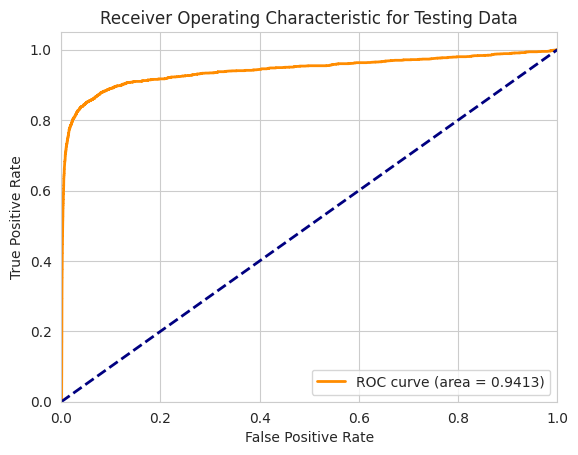

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba_gbm_hpo)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

# Score New Data Using GBM Model

In [ ]:
with zipfile.ZipFile('/content/project_2_holdout.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('')

holdout_df = pd.read_csv('project_2_holdout.csv')

holdout_df.head()

,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,...,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount
0,109420,4462,3648,54,6325,197.108.209.59,Opera/8.29.(X11; Linux i686; mk-MK) Presto/2.9...,perez-smith.org,+1-776-557-7526x274,Danielville,...,D,G,3/28/21 22:17,Mrs. Dawn Murray,414 Gregory Mountains Suite 443,618-52-2474,gd_GB,O,23.0,2422.0
1,1049060,3360,2180,54,4030,178.166.190.20,Opera/8.16.(X11; Linux i686; is-IS) Presto/2.9...,morris-diaz.com,001-427-310-1481x093,Thompsonshire,...,D,F,5/29/21 6:26,William Hughes,67405 Higgins Ways,651-14-8114,iu_CA,U,58.0,2160.0
2,2805320,4725,2063,60,4372,163.48.86.34,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,campos-brown.net,073.152.2261,North Lisaburgh,...,U,Z,3/17/21 7:35,Jennifer Johnson,41514 Toni Junction Suite 866,824-13-0148,yue_HK,O,34.0,14474.0
3,450840,5336,2319,72,4385,55.233.5.10,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10 1...,hanna-taylor.com,835-295-8283x42594,Joelville,...,X,W,4/26/21 5:34,Brenda Hopkins,1991 Angela Falls,633-56-8621,sa_IN,Y,84.0,13297.0
4,423160,6115,3413,61,5942,119.228.12.223,Opera/8.21.(X11; Linux i686; cv-RU) Presto/2.9...,gregory.com,424.203.8183,Hallburgh,...,D,W,1/17/21 13:25,Patricia Davis,57145 Walton Valleys Suite 250,636-15-1188,doi_IN,I,89.0,5425.0


In [ ]:
Scored_probs = gbm_pipeline_hpo.predict_proba(holdout_df)

threshold = 0.070762 # set the threshold to classify an event as fraud (firm wants 5% FPR)

Scored_class = (Scored_probs[:, 1] > threshold).astype('float')

In [ ]:
holdout_df['EVENT_LABEL'] = Scored_class
holdout_df['PROB_FRAUD']= Scored_probs[:,1]

In [ ]:
holdout_df['EVENT_LABEL'].value_counts(normalize=True)

0.0    0.90728
1.0    0.09272
Name: EVENT_LABEL, dtype: float64

In [ ]:
holdout_df.head(n=5)

,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,...,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL,PROB_FRAUD
0,109420,4462,3648,54,6325,197.108.209.59,Opera/8.29.(X11; Linux i686; mk-MK) Presto/2.9...,perez-smith.org,+1-776-557-7526x274,Danielville,...,3/28/21 22:17,Mrs. Dawn Murray,414 Gregory Mountains Suite 443,618-52-2474,gd_GB,O,23.0,2422.0,0.0,0.011433
1,1049060,3360,2180,54,4030,178.166.190.20,Opera/8.16.(X11; Linux i686; is-IS) Presto/2.9...,morris-diaz.com,001-427-310-1481x093,Thompsonshire,...,5/29/21 6:26,William Hughes,67405 Higgins Ways,651-14-8114,iu_CA,U,58.0,2160.0,0.0,0.003115
2,2805320,4725,2063,60,4372,163.48.86.34,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,campos-brown.net,073.152.2261,North Lisaburgh,...,3/17/21 7:35,Jennifer Johnson,41514 Toni Junction Suite 866,824-13-0148,yue_HK,O,34.0,14474.0,0.0,0.004790
3,450840,5336,2319,72,4385,55.233.5.10,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10 1...,hanna-taylor.com,835-295-8283x42594,Joelville,...,4/26/21 5:34,Brenda Hopkins,1991 Angela Falls,633-56-8621,sa_IN,Y,84.0,13297.0,0.0,0.003308
4,423160,6115,3413,61,5942,119.228.12.223,Opera/8.21.(X11; Linux i686; cv-RU) Presto/2.9...,gregory.com,424.203.8183,Hallburgh,...,1/17/21 13:25,Patricia Davis,57145 Walton Valleys Suite 250,636-15-1188,doi_IN,I,89.0,5425.0,0.0,0.009019


In [ ]:
predicted_events_gbm = holdout_df

In [ ]:
predicted_events_gbm.to_excel('Jack_Null_Project_2_Scored.xlsx')